In [1]:
# Librerias para manipulacion de Data y Gráficas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#Preparación de datos y configuración de pipeline para Machine Learning con scikit-learn
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

#models
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
#for classification
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#for regression
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('../../data/processed/dataset_cleaned.csv')

In [3]:
X = data.drop(['Und_2a_percentage', 'total_und', 'Und_1a', 'Und_2a'], axis=1)
y = data['Und_2a_percentage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (291865, 24)
X_test shape: (72967, 24)
y_train shape: (291865,)
y_test shape: (72967,)


In [4]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

# Remove target and intermediate columns from numerical_features
if 'Und_2a_percentage' in numerical_features:
    numerical_features.remove('Und_2a_percentage')
if 'total_und' in numerical_features:
    numerical_features.remove('total_und')
if 'Und_1a' in numerical_features:
    numerical_features.remove('Und_1a')
if 'Und_2a' in numerical_features:
    numerical_features.remove('Und_2a')


print("Updated Numerical Features:", numerical_features)
print("Updated Categorical Features:", categorical_features)

Updated Numerical Features: ['semana_anio', 'Tur', 'planta_id', 'seccion_id', 'maq_id', 'Pas', 'producto_id', 'estilo_id', 'Tal', 'Col', 'Tal_Fert', 'Col_Fert', 'Componentes', 'g_art_id', 'mp_id', 'Rechazo_comp', 'rechazo_flag', 'Tipo_2a_encoded']
Updated Categorical Features: ['Tipo_TEJ', 'Tecnologia', 'C', 'categoria_producto', 'MP', 'mp_categoria']


In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

print("Preprocessing pipeline created.")

Preprocessing pipeline created.


In [6]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("X_train_processed shape:", X_train_processed.shape)
print("X_test_processed shape:", X_test_processed.shape)

X_train_processed shape: (291865, 180)
X_test_processed shape: (72967, 180)


In [7]:
from tensorflow.keras import layers, callbacks
early_stopping = callbacks.EarlyStopping(patience = 2,
                                         min_delta = 0.001,
                                         restore_best_weights = True)

In [28]:
def plot_metrics(history):
    metrics = ['mse', 'mae']

    # Filtrar solo métricas que existan
    available = [m for m in metrics if m in history.history]

    if not available:
        print("No hay métricas disponibles para graficar.")
        return

    # Crear una figura con 1 fila y N columnas
    fig, axes = plt.subplots(1, len(available), figsize=(6 * len(available), 4))

    # Si solo hay 1 métrica, axes no es lista → lo convertimos
    if len(available) == 1:
        axes = [axes]

    for ax, metric in zip(axes, available):
        # Entrenamiento
        ax.plot(history.history[metric], label=f'Train {metric.upper()}')

        # Validación
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            ax.plot(history.history[val_metric], label=f'Val {metric.upper()}')

        ax.set_title(metric.upper())
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.upper())
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()

Modelo 1

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
model1 = keras.Sequential([
    layers.Input(shape=(X_train_processed.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear') # Output layer for regression
])

print("Neural network model built successfully.")
model1.summary()

Neural network model built successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        23,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,489 (123.00 KB)

 Trainable params: 31,489 (123.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae', 'mape'])

history1 = model1.fit(X_train_processed, y_train, epochs=50, batch_size=32, callbacks = [early_stopping])

print("Model compiled and trained successfully.")

Epoch 1/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0245 - mae: 0.0740 - mape: 11195060.0000 - mse: 0.0245
Epoch 2/50
  49/9121 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0200 - mae: 0.0624 - mape: 7625898.0000 - mse: 0.0200  

c:\Users\hjimenez\Desktop\Proyecto\Proyecto_analisis_intermedio_udea\.venv\lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape,mse
  current = self.get_monitor_value(logs)


9121/9121 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.0214 - mae: 0.0639 - mape: 6660603.0000 - mse: 0.0214
Epoch 3/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0211 - mae: 0.0628 - mape: 6138594.0000 - mse: 0.0211
Epoch 4/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0209 - mae: 0.0621 - mape: 5924098.5000 - mse: 0.0209
Epoch 5/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0207 - mae: 0.0617 - mape: 5807525.0000 - mse: 0.0207
Epoch 6/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - loss: 0.0206 - mae: 0.0612 - mape: 5529347.0000 - mse: 0.0206
Epoch 7/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0204 - mae: 0.0611 - mape: 5512709.0000 - mse: 0.0204
Epoch 8/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 0.0203 - mae: 0.0608 - mape: 5393259.5000 - mse: 0.0203
Epoch 9/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 0.0202 - mae: 0.0605 - mape: 5367019.5000 - mse: 0.0202
Epoch 10/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - l

In [10]:
y_pred1 = model1.predict(X_test_processed)
print("Predictions generated.")

2281/2281 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Predictions generated.


In [11]:
from sklearn.metrics import r2_score, mean_squared_error

# Calculate R-squared
r2 = r2_score(y_test, y_pred1)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred1)

print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R-squared: 0.8034
Mean Squared Error: 0.0214


Modelo 2

In [12]:
model2 = keras.Sequential([
    layers.Input(shape=(X_train_processed.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'), # Added a new Dense layer
    layers.Dropout(0.2), # Introduced a Dropout layer
    layers.Dense(1, activation='linear') # Output layer for regression
])

print("Refined neural network model built successfully.")
model2.summary()

Refined neural network model built successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        23,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,537 (131.00 KB)

 Trainable params: 33,537 (131.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae', 'mape'])

history2 = model2.fit(X_train_processed, y_train, epochs=50, batch_size=32, callbacks = [early_stopping])

print("Refined model compiled and trained successfully.")

Epoch 1/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0271 - mae: 0.0845 - mape: 13398799.0000 - mse: 0.0271
Epoch 2/50
  42/9121 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0266 - mae: 0.0811 - mape: 12928565.5952 - mse: 0.0266 

c:\Users\hjimenez\Desktop\Proyecto\Proyecto_analisis_intermedio_udea\.venv\lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape,mse
  current = self.get_monitor_value(logs)


9121/9121 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0239 - mae: 0.0784 - mape: 11284183.0000 - mse: 0.0239
Epoch 3/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0234 - mae: 0.0775 - mape: 11060942.0000 - mse: 0.0234
Epoch 4/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0231 - mae: 0.0767 - mape: 10766545.0000 - mse: 0.0231
Epoch 5/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0230 - mae: 0.0761 - mape: 10556140.0000 - mse: 0.0230
Epoch 6/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 0.0228 - mae: 0.0755 - mape: 10279404.0000 - mse: 0.0228
Epoch 7/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.0223 - mae: 0.0739 - mape: 9876747.0000 - mse: 0.0223
Epoch 8/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0222 - mae: 0.0732 - mape: 9547675.0000 - mse: 0.0222
Epoch 9/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0220 - mae: 0.0730 - mape: 9536470.0000 - mse: 0.0220
Epoch 10/50
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/ste

In [14]:
y_pred2 = model2.predict(X_test_processed)
print("Predictions generated.")

2281/2281 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Predictions generated.


In [15]:
r2 = r2_score(y_test, y_pred2)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred2)

print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R-squared: 0.8018
Mean Squared Error: 0.0216


Modelo 3

In [16]:
from tensorflow.keras.layers import LeakyReLU
model3 = keras.Sequential([
    layers.Input(shape=(X_train_processed.shape[1],)),
    layers.Dense(128, activation=LeakyReLU(alpha=0.2)),
    layers.Dense(64, activation=LeakyReLU(alpha=0.2)),
    layers.Dense(32, activation=LeakyReLU(alpha=0.2)), # Added a new Dense layer
    layers.Dropout(0.2), # Introduced a Dropout layer
    layers.Dense(1, activation='linear') # Output layer for regression
])

print("Refined neural network model built successfully.")
model2.summary()

Refined neural network model built successfully.


c:\Users\hjimenez\Desktop\Proyecto\Proyecto_analisis_intermedio_udea\.venv\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │        23,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,613 (393.02 KB)

 Trainable params: 33,537 (131.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 67,076 (262.02 KB)

In [17]:
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse','mae', 'mape'])

history3 = model3.fit(X_train_processed, y_train, epochs=25, batch_size=32, callbacks = [early_stopping])

print("Refined model compiled and trained successfully.")

Epoch 1/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.0320 - mae: 0.0870 - mape: 15701226.0000 - mse: 0.0320
Epoch 2/25
  58/9121 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.0232 - mae: 0.0747 - mape: 11060318.7759 - mse: 0.0232

c:\Users\hjimenez\Desktop\Proyecto\Proyecto_analisis_intermedio_udea\.venv\lib\site-packages\keras\src\callbacks\early_stopping.py:99: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mape,mse
  current = self.get_monitor_value(logs)


9121/9121 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.0233 - mae: 0.0753 - mape: 10530312.0000 - mse: 0.0233
Epoch 3/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0226 - mae: 0.0729 - mape: 9402781.0000 - mse: 0.0226
Epoch 4/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0223 - mae: 0.0719 - mape: 8961202.0000 - mse: 0.0223
Epoch 5/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0221 - mae: 0.0714 - mape: 8740479.0000 - mse: 0.0221
Epoch 6/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.0220 - mae: 0.0713 - mape: 8760609.0000 - mse: 0.0220
Epoch 7/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.0219 - mae: 0.0710 - mape: 8742996.0000 - mse: 0.0219
Epoch 8/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 0.0218 - mae: 0.0708 - mape: 8679592.0000 - mse: 0.0218
Epoch 9/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.0218 - mae: 0.0708 - mape: 8656218.0000 - mse: 0.0218
Epoch 10/25
9121/9121 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - 

In [25]:
y_pred3 = model3.predict(X_test_processed)
print("Predictions generated.")

2281/2281 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Predictions generated.


In [27]:
r2 = r2_score(y_test, y_pred3)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred3)

print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R-squared: 0.8021
Mean Squared Error: 0.0215


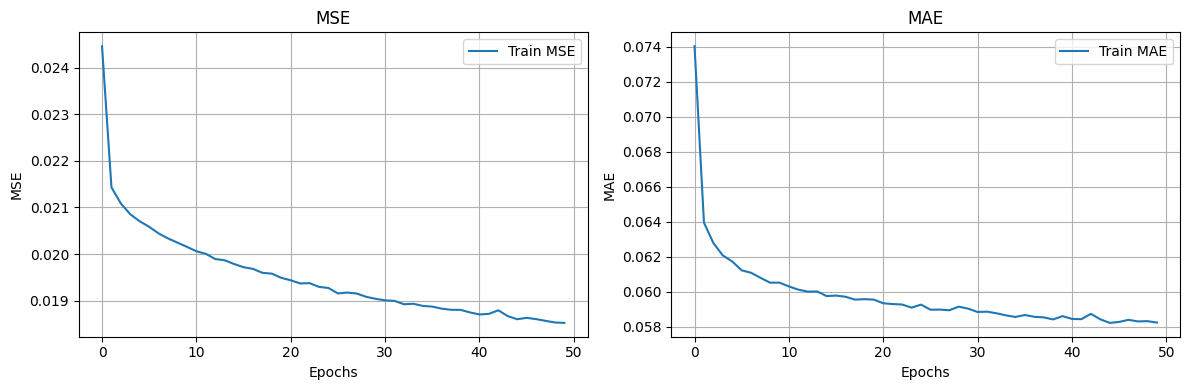

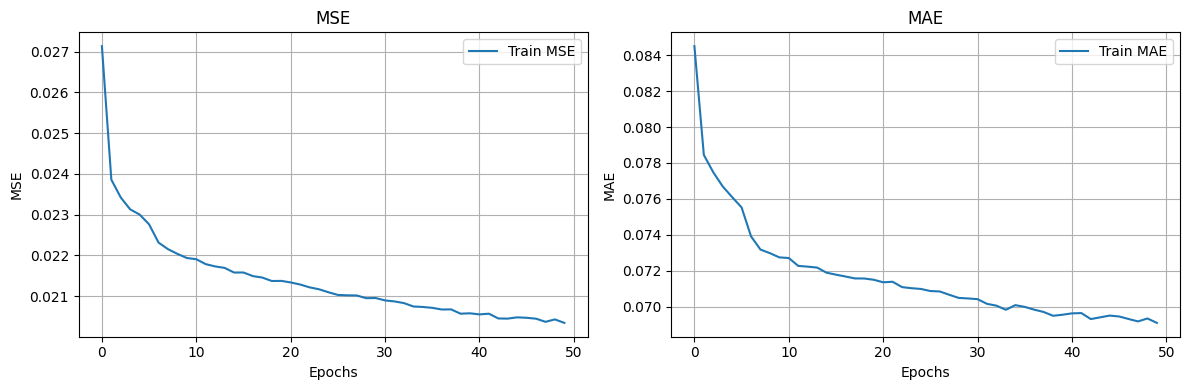

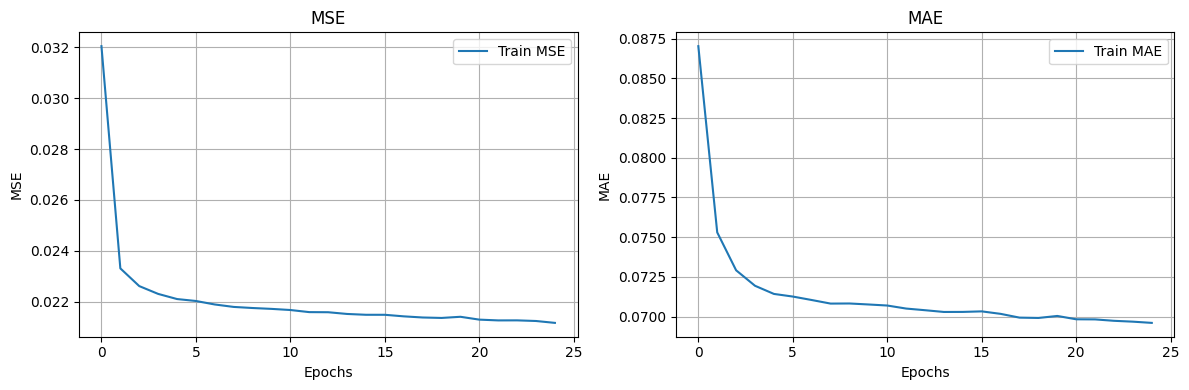

In [23]:
plot_metrics(history1)
plot_metrics(history2)
plot_metrics(history3)

In [43]:
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [50]:
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object", "category"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
    ]
)

xgb_model = XGBRegressor(
    n_estimators=700,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.3,
    reg_lambda=1.5,
    random_state=42,
    objective="reg:squarederror",
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", xgb_model)
])


In [52]:
df = data.sort_values("semana_anio")

split_week = df["semana_anio"].quantile(0.8)

train_df = df[df["semana_anio"] <= split_week]
test_df  = df[df["semana_anio"] >  split_week]

X_train = train_df.drop("Und_2a_percentage", axis=1)
y_train = train_df["Und_2a_percentage"]

X_test = test_df.drop("Und_2a_percentage", axis=1)
y_test = test_df["Und_2a_percentage"]


In [54]:
q_low  = y_train.quantile(0.01)
q_high = y_train.quantile(0.99)
mask = (y_train >= q_low) & (y_train <= q_high)

X_train = X_train[mask]
y_train = y_train[mask]
